# paper <the MIT humanoid robot: design, motion planning, and control for acrobatic behaviors>

## 1 Introduction
人工寻找一条humanoid完成后空翻的轨迹基本是不可能的（gait library的做法，极高的自由度），因而需要使用基于优化方法的轨迹规划来完成。使用full-body动力学方法缺点在计算效率、局部最优等问题；利用弹簧质量模型的缺点在于很多严格假设限制了模型的通用性。质心动力学模型可以被较好地应用于motion planning。

对于机器人后空翻落地的动作，需要让机器人在后空翻过程耗散掉动能，并且能够迅速在触地瞬间来控制姿态维持稳定。文章提出使用MPC+WBIC的控制框架。不同于在Cheeta Mini中的框架（MPC和VBIC使用相同的位置期望），humanoid在做后空翻动作时，MPC的作用是规划轨迹耗散动能；WBIC将MPC计算出的position command和reaction force command作为期望进行控制，同时WBIC还有一个高优先级任务：保持身体朝向。
## 2 humanoid
该机器人每条腿配备5个驱动器：3个hip的ab-ad/yaw/pitch，剩余2个分别是膝关节和踝关节（膝关节电机力矩最大，hip的pitch关节力矩次之，踝关节和肘关节电机力矩第三，其余关节力矩一样）。足底装备有4个无线的接触传感器来检测落地。
## planning and control
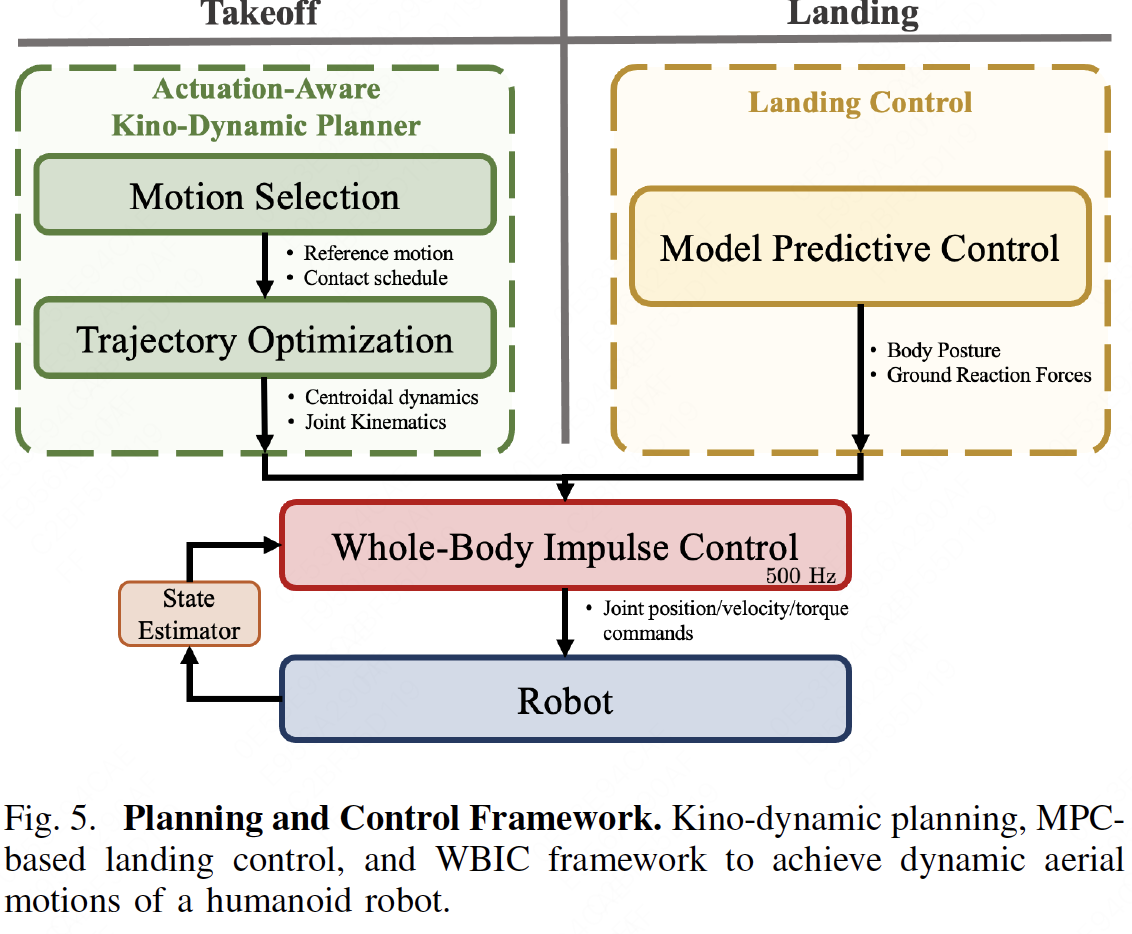
## planning
完成backflip这样一个动作，PNC框架主要分为3个部分：motion selector，optimizer，controller。motion selector的作用是选择机器人的动作，比如跳上桌子或者backflip。motion selector根据机器人的初始、末端状态进行插值，得到一条参考轨迹reference motion$X_{ref}$。optimizer的作用是根据质心动力学方程，让机器人的生成尽量逼近reference motion的、可行的动作$X$。优化轨迹求解过程中主要有3部分的约束条件：（1）动力学约束，包括牛顿力学、角动量、角动量变化量；（2）humanoid的重心和末端位置约束；（3）接触和非接触约束。

optimizer采取kino-dynamic planner，可以考虑actuator的力矩能力范围。在slow-motion中，关节力矩是通过cost function 或者直接显示地添加关节力矩约束来实现的。在highly dynamic motions等逼近硬件极限的动作中，首先利用动力学方程求解得到关节力矩，动力学方程为$ H \ddot{q} + C \dot{q} +\tau_G = B \tau_j + \sum_{i=1}^{n_c} J_{c,i}^T f_{c, i}$, 因而有 $$\tau_j = S_j (H \ddot{q} + C \dot{q} +\tau_G-\sum_{i=1}^{n_c} J_{c,i}^T f_{c, i})$$ 
经验上，接触力矩是上述方程的主要部分，因而可以认为$$ \tau_j \approx S_j (-\sum_{i=1}^{n_c} J_{c,i}^T f_{c, i})$$

上述近似降低了关节力矩求解的非线性，但依然由于碰撞而存在严重的非线性。根据对acrobatic motion的观察，leg的触地雅可比矩阵对hip yaw，hip ab/ad和ankle joint的角度不敏感，因而触地雅可比矩阵对这三个状态量进行线性化来进一步降低非线性。
## control
机器人检测到落地后，landing controller就开始工作：absorbing impact和dissipating kinetic energy。

MPC部分使用简化的lumped mass model，并使用线性时不变的方程表述，同时对float base的姿态用欧拉角来表述。在后空翻的过程中，MPC假定在一个求解周期内，float base的姿态不会发生大的变化。具体的MPC求解表述参考原文。

